In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from banditfriday.simulation import simulate
from banditfriday.datagen import generate_product_data
from banditfriday.products import plot_product_probabilities, plot_max_probabilities, ALL_PRODUCTS
from banditfriday.strategies.baseline_strategy import BaselineStrategy
from banditfriday.strategies.binned_strategy import BinnedStrategy
from banditfriday.strategies.thompson_strategy import ThompsonSampling
from banditfriday.strategies.cheating_strategy import CheatingStrategy

# Bandit Friday

Have you ever implemented your own bandit algorithm? Want to know how to get started? Read on to find out how to create simple contextual bandits from scratch.

This blog is a result of a Friday hackathon (this explains the title) where some colleagues and me set out to explore contextual bandits. Our aim was to build the simplest version of a contextual bandit we could think of.

The outline of this blog is as follows:
- What is a (contextual) bandit?
- What is the practical use case?
- What is the line-up?
- How to test our bandits?
- Who is the winner?
- It's a wrap

## What is a (contextual) bandit?

The multi-armed bandit problem originates from the hypothetical experiment of choosing the best arm on a slot machine. Not knowing which arm will give the best reward, the idea is to experimentally find out by randomly pulling arms and continuing (exploiting) to pull arms with the highest rewards.

A contextual bandit is a bandit algorithm where the reward depends on the context (also called environment). For example, assume that the pay out of the slot machine depends on the age of the person pulling the arm. Then we want to find out for each age (or age group) the arm with the highest reward. Of course, for a fair slot machine the context should not influence the outcome, but in practical applications where bandit algorithms are used the context will often have an impact.

The more context you take into account, however, the more time it takes to learn the optimal action for each context.

## What is the practical use case?

The application we had in mind was to recommend products to customers. Translating to slot machines this means that each product is an arm on the slot machine. We assume that the buying/click probability for each customer for each product depends on both age and wealth (this is the context that the contextual bandit should learn). Again in the context of slot machines this means that age and wealth of the person pulling the arm influences the reward.

Such a recommendation setting has many real world applications, such as the recommending of products on e-commerce websites like Bol.com and Amazon. Also the recommendation of content on e.g. Netflix or advertisements by Google are very similar.


## What is the line-up?

### Baseline bandit
The baseline bandit learns from historic data the overall click/buy rate per product. It always recommends the product with the highest click/buy rate, and therefore doesn't learn after the initial training stage.

### Thompson sampling bandit
> Thompson sampling, named after William R. Thompson, is a heuristic for choosing actions that addresses the exploration-exploitation dilemma in the multi-armed bandit problem. It consists of choosing the action that maximizes the expected reward with respect to a randomly drawn belief. 

The bandit based on Thompson sampling (see Wikipedia's definition above) works as follows. For each product it samples a buy/click probability based on the beta distribution learned from historic data and picks the best product accordingly. After each recommendation the probabilities are updated. As a result this bandit will keep learning since even low buy/click probability products have a chance to be chosen.

### Contextual bandit
This is actually a wrapper bandit as it bins age and wealth and applies a bandit of choice to each bin. That is, the problem is broken up into many sub-problems which are solved independently.

The number of bins to use is a trade-off between the flexibility to learn and the amount of data you have (or the time it takes to collect it). It is a parameter from which equal width bins are created.

### Cheating bandit
To see how far off we are from the optimal performance we created a cheating bandit that uses the probabilities used for data generation to determine which products will have the highest click/buy rate for any given context. Only luck can get you better performance.

## How to test our bandits?

To verify the quality of the bandit algorithms we will create we need to  define the system that will determine the reward for each action in each context. Using existing data sets will give us little control and therefore we chose to generate data such that we can create a variety of different products with different rewards and varying impact of the context.

For each product we choose a specific distribution (we use wildly varying shapes) that determines the expected reward for each context. E.g. for potatoes the click/buy probability is max(0, age - wealth^2).

From these distributions we can then sample training data. And after training we can sample as many test records as we want to fairly determine the performance of each bandit.

Below a sample of generated data. Each record represents how a customer with a specific context (age and wealth) would react to each of the products, i.e. would they buy/click.

In [3]:
training_data = generate_product_data(size=1000)
training_data.head()

,id,age,wealth,Beer,CheapToiletPaper,Diapers,Lollipops,Raspberries,Potatoes,Sushi
0,0,0.943719,0.258836,True,False,False,False,False,False,False
1,1,0.435712,0.728221,False,False,False,False,False,False,True
2,2,0.464335,0.680780,True,False,False,False,False,False,False
3,3,0.524840,0.792029,False,False,True,True,False,False,False
4,4,0.734422,0.783696,False,False,False,False,True,False,False


These are the steps to sample a single record:
1. randomly sample the context for a customer: age and wealth (for simplicity both between 0 and 1)
2. from the distribution defined for each product, sample the buy/click behavior (True or False) based on the sampled context from step 1.

For example, for the first record, first the age and wealth are randomly sampled between 0 and 1 to be 0.82 and 0.33, respectively. Then for each of the products we look at the chosen conditional probabilities to sample True or False for the buy/click action. For potatoes the conditional probability for the given age and wealth is 0.82-0.33^2 = 0.71. We thus sample True with a probability of 0.71 and False with a probability of 0.29.

Below you see a visualization of the chosen conditional buying probabilities for each of our products based on age and wealth (the axis show 0 to 100 instead of 0 to 1).

From these plots you can see for example that we generated data where raspberries are more likely to be bought by old and wealthy people. And cheap toilet paper only with a small probability by very poor people and not at all by the rest.

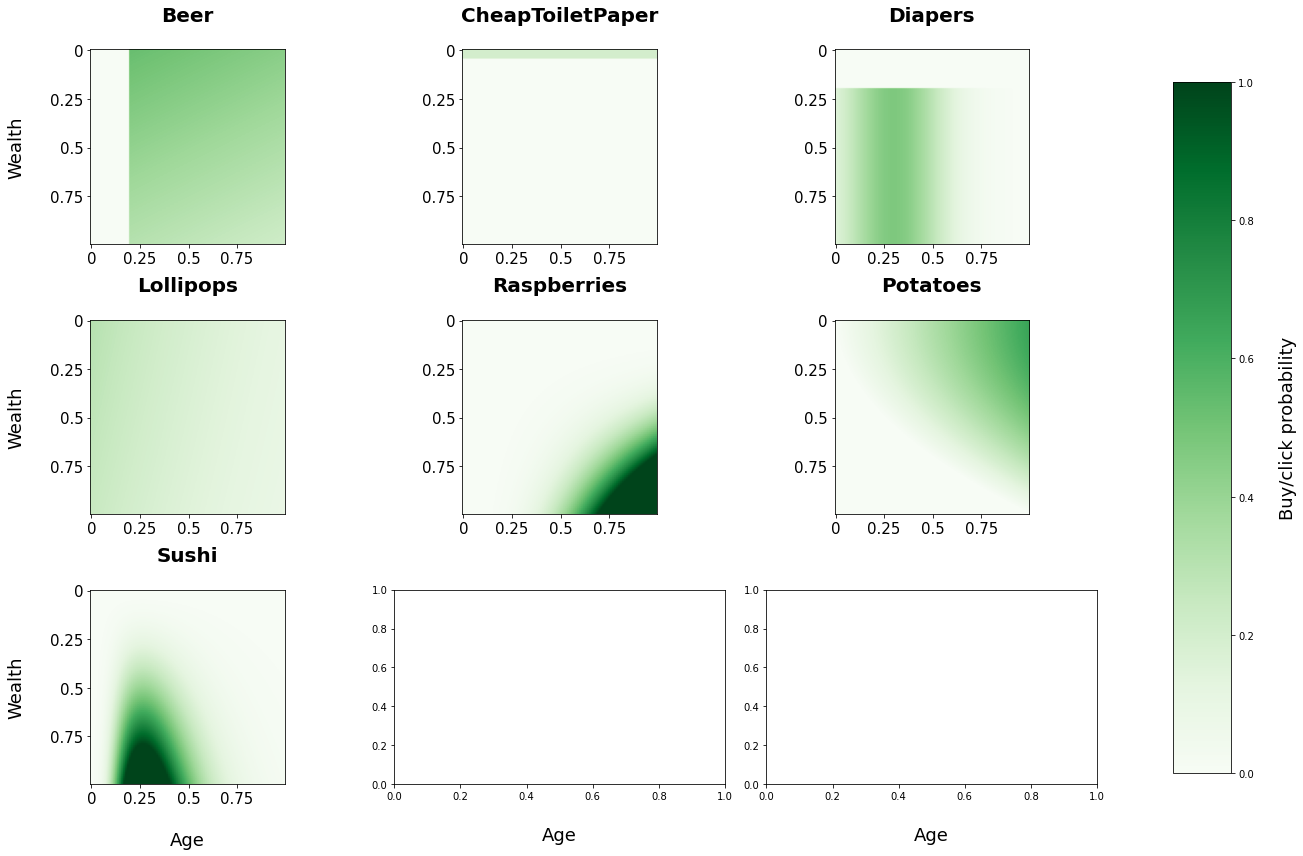

In [54]:
plot_product_probabilities(ALL_PRODUCTS)

The plot below shows for each context (combination of age and wealth) which product is most popular.

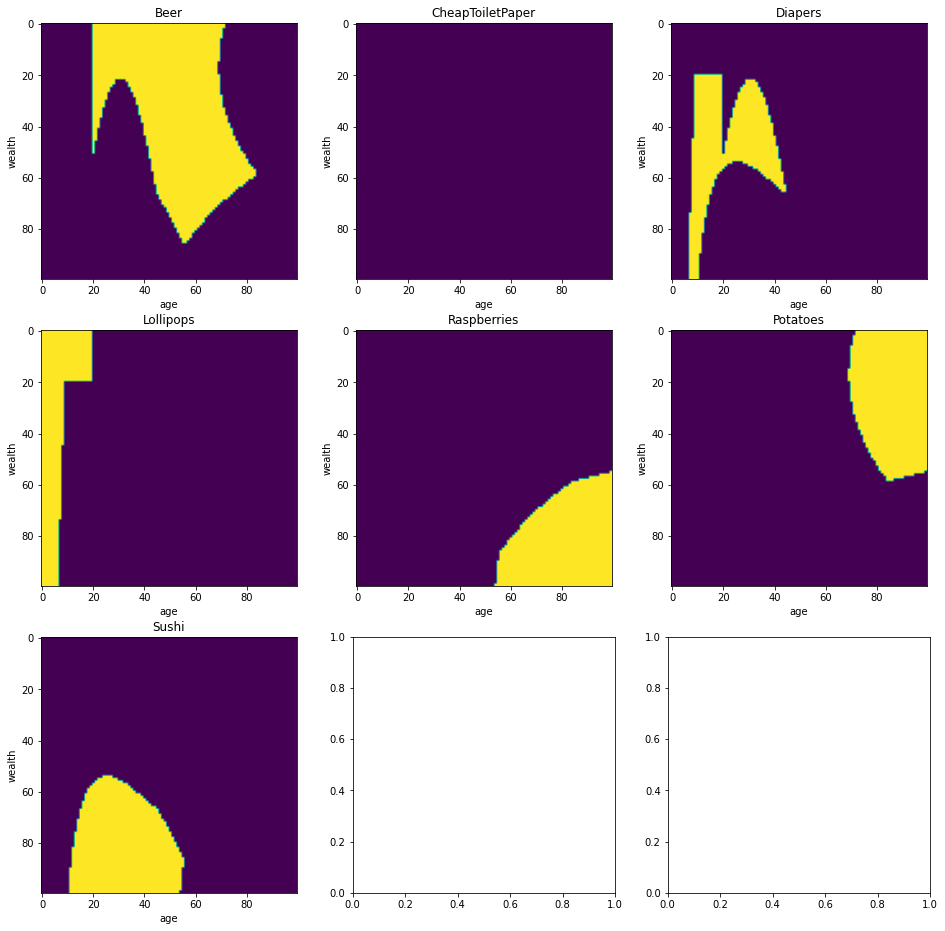

In [5]:
plot_max_probabilities(ALL_PRODUCTS)

## Who is the winner?

We created a simulator to score the different bandits. Each bandit has the option to train on some historic data (1,000 records). Also, each bandit can either be vanilla or the contextual variant with binning. Below the results on 10,000 recommendations.

In [6]:
strategies = [CheatingStrategy(products=ALL_PRODUCTS)]

for history in (None, training_data):        
    for strategy in (
        BaselineStrategy(products=ALL_PRODUCTS, history=history), 
        BinnedStrategy(BaselineStrategy, products=ALL_PRODUCTS, history=history),
        ThompsonSampling(products=ALL_PRODUCTS, history=history),
        BinnedStrategy(ThompsonSampling, products=ALL_PRODUCTS, history=history)
    ):
        strategies.append(strategy)

simulate(strategies, steps=10_000)

CheatingStrategy
	Total reward: 4991 out of 10000
BaselineStrategy
	Total reward: 2955 out of 10000
BaselineStrategy - Binned
	Total reward: 3045 out of 10000
ThompsonSampling
	Total reward: 2879 out of 10000
ThompsonSampling - Binned
	Total reward: 4026 out of 10000
BaselineStrategy - with training data
	Total reward: 3068 out of 10000
BaselineStrategy - Binned - with training data
	Total reward: 4253 out of 10000
ThompsonSampling - with training data
	Total reward: 3029 out of 10000
ThompsonSampling - Binned - with training data
	Total reward: 4214 out of 10000


### Observations

* As expected the contextual bandits easily outperform the vanilla bandits.
* The baseline needs training data to be able to perform well since it doesn't explore, without training data is is just a random guess.
* Without training data the baseline was lucky that it by chance picked a product with a high overall conversion rate.
* It is surprising that the contextual baseline with training outperforms the contextual Thompson sampling bandit, since it is such a simple algorithm.
* The Thompson sampling bandit will probably generalize better than the baseline, e.g. when there isn't a single product that is very popular in each context. Or when the probabilities change over time it is able to learn and adept after initialization.

### Are these bandits any good?

Looking at the performance of the cheating bandit (almost 50%), a conversion of 43% for the runner-up seems pretty good. Especially taking into account how simple these bandits are. They can be implemented in only a few lines of code.

## It's a wrap

We've created some simple bandit algorithms and created context aware variations of them. On some generated data we concluded that these simple algorithms perform pretty decently.